Ruth Sadler 10/06/2024

#Example Dashboard

###Filled Polygon
The `plt.fill()` function draws a filled polygon based on lists of point coordinates x, y.

This example uses the Koch snowflake as an example polygon.

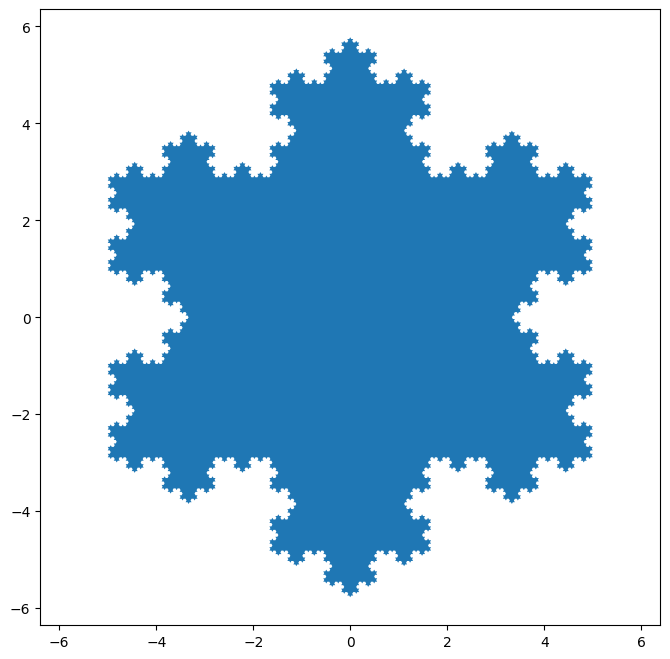

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def koch_snowflake(order, scale=10):
    """
    Return two lists x, y of point coordinates of the Koch snowflake.

    Parameters
    ----------
    order : int
        The recursion depth.
    scale : float
        The extent of the snowflake (edge length of the base triangle).
    """
    def _koch_snowflake_complex(order):
        if order == 0:
            # initial triangle
            angles = np.array([0, 120, 240]) + 90
            return scale / np.sqrt(3) * np.exp(np.deg2rad(angles) * 1j)
        else:
            ZR = 0.5 - 0.5j * np.sqrt(3) / 3

            p1 = _koch_snowflake_complex(order - 1)  # start points
            p2 = np.roll(p1, shift=-1)  # end points
            dp = p2 - p1  # connection vectors

            new_points = np.empty(len(p1) * 4, dtype=np.complex128)
            new_points[::4] = p1
            new_points[1::4] = p1 + dp / 3
            new_points[2::4] = p1 + dp * ZR
            new_points[3::4] = p1 + dp / 3 * 2
            return new_points

    points = _koch_snowflake_complex(order)
    x, y = points.real, points.imag
    return x, y

x, y = koch_snowflake(order=5)

plt.figure(figsize=(8, 8))
plt.axis('equal')
plt.fill(x, y)
plt.show()

###Interactive Adjustment of Colourmap Range
Demonstration of how a colorbar can be used to interactively adjust the range of colormapping on an image. To use the interactive feature, you must be in either zoom mode (magnifying glass toolbar button) or pan mode (4-way arrow toolbar button) and click inside the colorbar.

When zooming, the bounding box of the zoom region defines the new vmin and vmax of the norm. Zooming using the right mouse button will expand the vmin and vmax proportionally to the selected region, in the same manner that one can zoom out on an axis. When panning, the vmin and vmax of the norm are both shifted according to the direction of movement. The Home/Back/Forward buttons can also be used to get back to a previous state.

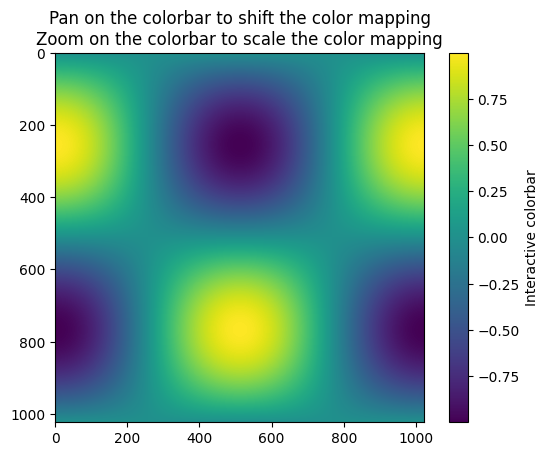

In [2]:
import matplotlib.pyplot as plt
import numpy as np

t = np.linspace(0, 2 * np.pi, 1024)
data2d = np.sin(t)[:, np.newaxis] * np.cos(t)[np.newaxis, :]

fig, ax = plt.subplots()
im = ax.imshow(data2d)
ax.set_title('Pan on the colorbar to shift the color mapping\n'
             'Zoom on the colorbar to scale the color mapping')

fig.colorbar(im, ax=ax, label='Interactive colorbar')

plt.show()

###Time Series Histograms

This example demonstrates how to efficiently visualize large numbers of time series in a way that could potentially reveal hidden substructure and patterns that are not immediately obvious, and display them in a visually appealing way.

In this example, we generate multiple sinusoidal "signal" series that are buried under a larger number of random walk "noise/background" series. For an unbiased Gaussian random walk with standard deviation of $σ$, the RMS deviation from the origin after n steps is $σ*sqrt(n)$. So in order to keep the sinusoids visible on the same scale as the random walks, we scale the amplitude by the random walk RMS. In addition, we also introduce a small random offset $'phi$ to shift the sines left/right, and some additive random noise to shift individual data points up/down to make the signal a bit more "realistic" (you wouldn't expect a perfect sine wave to appear in your data).

The first plot shows the typical way of visualizing multiple time series by overlaying them on top of each other with `plt.plot` and a small value of $alpha$. The second and third plots show how to reinterpret the data as a 2d histogram, with optional interpolation between data points, by using `np.histogram2d` and `plt.pcolormesh`.

0.246 sec. elapsed
0.095 sec. elapsed


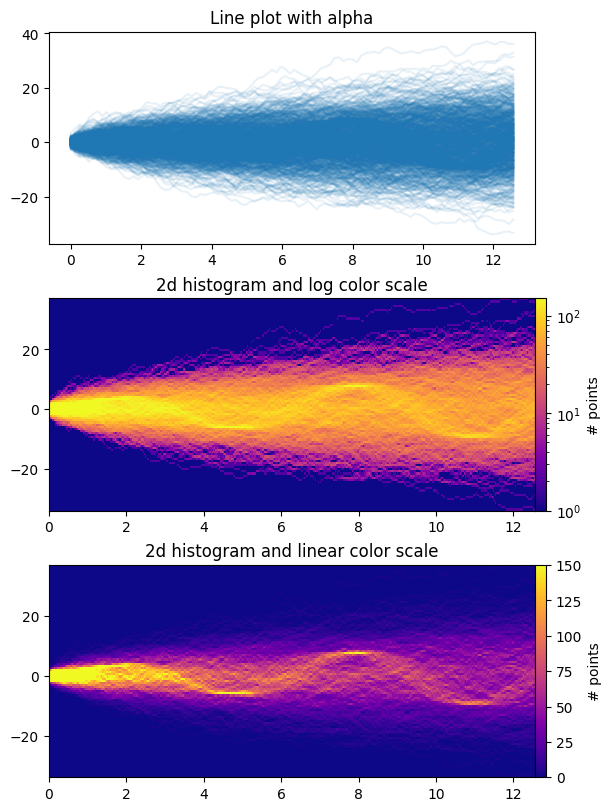

In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=3, figsize=(6, 8), layout='constrained')

# Fix random state for reproducibility
np.random.seed(19680801)
# Make some data; a 1D random walk + small fraction of sine waves
num_series = 1000
num_points = 100
SNR = 0.10  # Signal to Noise Ratio
x = np.linspace(0, 4 * np.pi, num_points)
# Generate unbiased Gaussian random walks
Y = np.cumsum(np.random.randn(num_series, num_points), axis=-1)
# Generate sinusoidal signals
num_signal = round(SNR * num_series)
phi = (np.pi / 8) * np.random.randn(num_signal, 1)  # small random offset
Y[-num_signal:] = (
    np.sqrt(np.arange(num_points))  # random walk RMS scaling factor
    * (np.sin(x - phi)
       + 0.05 * np.random.randn(num_signal, num_points))  # small random noise
)


# Plot series using `plot` and a small value of `alpha`. With this view it is
# very difficult to observe the sinusoidal behavior because of how many
# overlapping series there are. It also takes a bit of time to run because so
# many individual artists need to be generated.
tic = time.time()
axes[0].plot(x, Y.T, color="C0", alpha=0.1)
toc = time.time()
axes[0].set_title("Line plot with alpha")
print(f"{toc-tic:.3f} sec. elapsed")


# Now we will convert the multiple time series into a histogram. Not only will
# the hidden signal be more visible, but it is also a much quicker procedure.
tic = time.time()
# Linearly interpolate between the points in each time series
num_fine = 800
x_fine = np.linspace(x.min(), x.max(), num_fine)
y_fine = np.concatenate([np.interp(x_fine, x, y_row) for y_row in Y])
x_fine = np.broadcast_to(x_fine, (num_series, num_fine)).ravel()


# Plot (x, y) points in 2d histogram with log colorscale
# It is pretty evident that there is some kind of structure under the noise
# You can tune vmax to make signal more visible
cmap = plt.colormaps["plasma"]
cmap = cmap.with_extremes(bad=cmap(0))
h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])
pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm="log", vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[1], label="# points", pad=0)
axes[1].set_title("2d histogram and log color scale")

# Same data but on linear color scale
pcm = axes[2].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[2], label="# points", pad=0)
axes[2].set_title("2d histogram and linear color scale")

toc = time.time()
print(f"{toc-tic:.3f} sec. elapsed")
plt.show()